In [1]:
import os
os.chdir("/Users/Layne/Desktop/aiqc")

In [2]:
import aiqc
from aiqc import examples

/Users/layne/.pyenv/versions/3.7.6/envs/jupyterlab/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
hf_path = examples.get_demo_file_path('heart_failure.parquet')

In [4]:
dataset = aiqc.Dataset.Tabular.from_path(hf_path, source_file_format='parquet')

In [21]:
label = dataset.make_label(columns=['age'])

In [22]:
featureset = dataset.make_featureset(exclude_columns=['age'])

In [23]:
splitset = featureset.make_splitset(
        label_id = label.id
		, size_test = 0.20
        , bin_count = 3
)

---

In [24]:
import keras
from keras import metrics
from keras.models import Sequential
from keras.callbacks import Callback, History
from keras.layers import Conv1D, Dense, Dropout
from keras.constraints import maxnorm
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten

In [38]:
def function_model_build(**hyperparameters):
    model = Sequential()
    
    model.add(Dense(hyperparameters['neuron_count'], activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(hyperparameters['neuron_count'], activation='relu'))
    
    if hyperparameters['third_dense']:
        model.add(Dropout(0.2))
        model.add(Dense(hyperparameters['neuron_count'], activation='relu'))

    model.add(Dense(1, kernel_initializer='normal'))
    
    
    opt = keras.optimizers.Adamax(hyperparameters['learning_rate'])
    model.compile(
		loss='mean_squared_error'
		, optimizer=opt
		, metrics = ['mean_squared_error']
	)
    return model

In [39]:
def function_model_train(model, samples_train, samples_evaluate, **hyperparameters):   
    
    metrics_cuttoffs = [
        {"metric":"val_loss", "cutoff":2, "above_or_below":"below"},
        {"metric":"loss", "cutoff":2, "above_or_below":"below"}
    ]
    cutoffs = aiqc.TrainingCallback.Keras.MetricCutoff(metrics_cuttoffs)
    
    model.fit(
        samples_train["features"]
        , samples_train["labels"]
        , validation_data = (
            samples_evaluate["features"]
            , samples_evaluate["labels"]
        )
        , verbose = 0
        , batch_size = hyperparameters['batch_size']
        , callbacks=[History(), cutoffs]
        , epochs = hyperparameters['epoch_count']
    )

    return model

In [40]:
algorithm = aiqc.Algorithm.make(
    library = "keras"
    , analysis_type = "regression"
    , function_model_build = function_model_build
    , function_model_train = function_model_train
)

In [45]:
hyperparameters = {
    "batch_size": [3]
    , "third_dense": [True, False]
    , "epoch_count": [600, 1200]
    , "neuron_count": [32,64,128]
    , "learning_rate": [0.05, 0.01]
}

In [46]:
hyperparamset = aiqc.Hyperparamset.from_algorithm(
    algorithm_id = algorithm.id
    , hyperparameters = hyperparameters
)

In [47]:
batch = aiqc.Batch.from_algorithm(
    algorithm_id = algorithm.id
    , splitset_id = splitset.id
    , hyperparamset_id = hyperparamset.id
)

In [48]:
batch.run_jobs()

🔮 Training Models 🔮: 100%|█████████████████████████████████████| 24/24 [4:56:46<00:00, 741.95s/it]


In [50]:
batch.statuses_to_pandas()

job_id,status
746,Succeeded
747,Succeeded
748,Succeeded
749,Succeeded
750,Succeeded
751,Succeeded
752,Succeeded
753,Queued
754,Queued
755,Queued


In [33]:
batch.metrics_to_pandas()

job_id,split,explained_variance,loss,mse,r2
721,test,0.000000,130.574738,130.574738,-0.000192
721,train,0.000000,143.633926,143.633927,-0.000006


In [34]:
aiqc.Job.get_by_id(720).hyperparamcombo.hyperparameters_to_pandas()

param,value
batch_size,3.000000
epoch_count,600.000000
neuron_count,64.000000
learning_rate,0.050000


In [57]:
aiqc.Job.get_by_id(720).results[0].probabilities

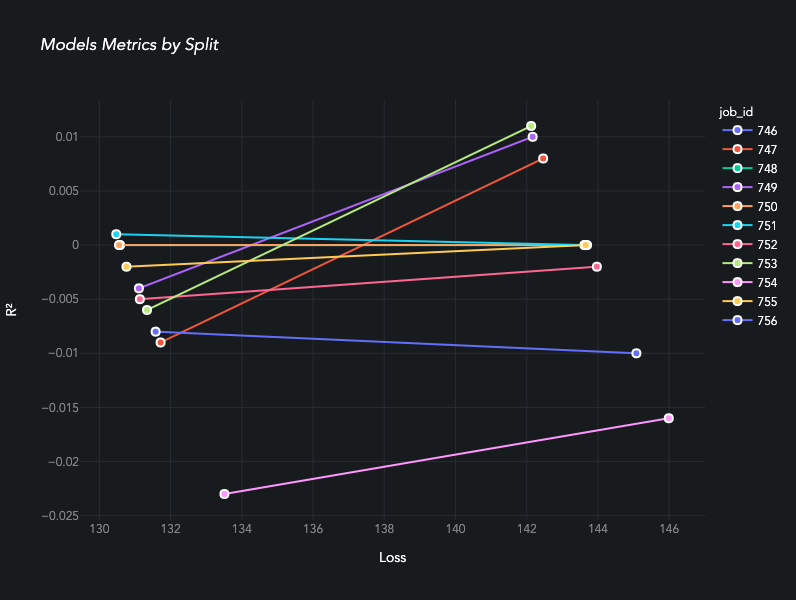

In [52]:
batch.plot_performance(max_loss=1000, min_metric_2=-1)

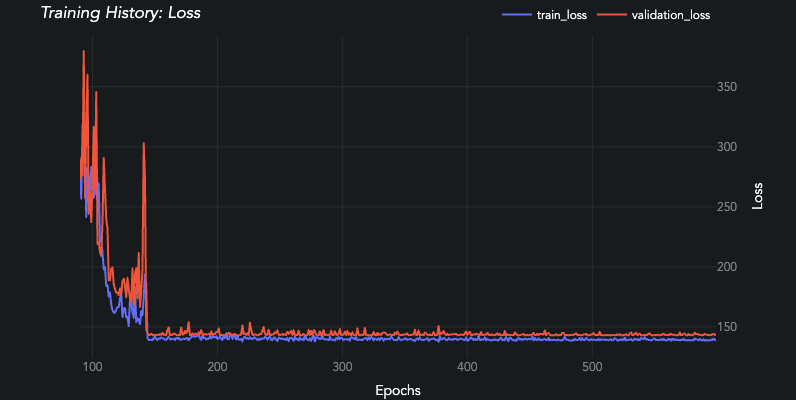

In [146]:
aiqc.Job.get_by_id(719).results[0].plot_learning_curve(loss_last_85pct=True)